In [374]:
import pandas as pd

from openpyxl import load_workbook

import numpy as np
import uncertainties as uc

pd.options.display.float_format ='{:,.1f}'.format
import matplotlib.pyplot as plt

%matplotlib inline  

import scipy.stats as stats
from uncertainties import ufloat
from uncertainties import unumpy
from sklearn.linear_model import LinearRegression

from scipy.stats import gmean
%run Utility_Functions.ipynb

# Lung cells
There are several distinct population of cellss in the lungs. The main cell types we take in account in our estimates are:
1. alveolar epithelial cells - there are two types (I,II) that lines the lung alveoli, which are the ends of the respiratory tree. Type I cells are involved in the process of gas exchange between the alveoli and blood. Type II are the progenitor stem cells of type I cells
2. The alveolar macrophages reside on the internal lumenal surfaces of the alveoli, the alveolar ducts, and the bronchioles. They are mobile scavengers that serve to engulf foreign particles in the lungs, such as dust, bacteria, carbon particles, and blood cells from injuries
3. Bronchial and bronchioles epithelial cells that lined the respiratory tract.
4. Interstitial cells -  interstitium  is the tissue and space around the alveoli. There are different cells in this area, one of the important is fibroblast, which is responsible for the extracellular matrix.
5. Endothelial cells- makes the numerous blood vessels in the lungs. As we acounted for their number and turnover in the estimate for the total endothelial turnover we *don't include* them in the current estimate 

## Number of cells
We use data from three sources that estiamted the number of different cells in the lungs of adult humans and average their results: [Crapo et al., 1982](https://www.ncbi.nlm.nih.gov/pubmed/7103258), [Stone et al., 1992](https://www.ncbi.nlm.nih.gov/pubmed/1540387), [Mercer et al.,1994](https://www.ncbi.nlm.nih.gov/pubmed/8003339)

In [364]:
#laoding the data from excel
cell_num_data = pd.read_excel('Lung_cells_data.xlsx','Cell_number', index_col=0, usecols=range(8))
#droping the endothelial cells, which were analysed in a specific manner
cell_num_data = cell_num_data.drop('Endothelial cells')

#combining the measured mean values and their SEM using uncertainty package 
cell_num_data['Crapo'] = unumpy.uarray(cell_num_data['number of cell (Crapo et al., 1982)'],cell_num_data['SEM of cells (Crapo et al., 1982)'])
cell_num_data['Stone'] = unumpy.uarray(cell_num_data['number of cell (Stone et al., 1992)'],cell_num_data['SEM of cells (Stone et al., 1992)'])
cell_num_data['number']  = (cell_num_data['Crapo']+cell_num_data['Stone'])/2

#adding the borncial epithelial cells wich were estimated only in a seperated source
cell_num_data.loc[['Bronchi epithelia','Bronchioles epithelia'],'number'] = unumpy.uarray(cell_num_data.loc[['Bronchi epithelia','Bronchioles epithelia'],'number of cell (Mercer et al., 1994)'],
                                                                                       cell_num_data.loc[['Bronchi epithelia','Bronchioles epithelia'],'SEM of cells (Mercer et al., 1994)'])

#combining the results and saving them in a dedicated data frame
lung_results = pd.DataFrame(index = cell_num_data.groupby('cell type').sum().index,
                       columns=['number','lifespan','cellular turnovr rate','cell mass','cellular mass turnovr rate','total cellular mass'])
lung_results['number'] = cell_num_data[['cell type','number']].groupby('cell type').sum()


C:\Users\ronse\anaconda3\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


In [428]:
FORMATS =  dict(zip(lung_results.columns, ['{:0.1e}','{:0.0f}','{:0.1e}','{:0.0f}','{:0.1f}','{:0.0f}'])) 
UNITS =dict(zip(lung_results.columns, ['cells','days','cells per day','pg','grams per day', 'grams']))

'''
A utility method for printing a parameter with a multiplication uncertainty
 '''
def PrintMulParmeter(cell_type,param):
    print(param.capitalize()+ ' of '+ cell_type+': '+ FORMATS.get(param).format(lung_results.loc[cell_type,param][0]),UNITS.get(param)+',',
          'SD range: ' + FORMATS.get(param).format(lung_results.loc[cell_type,param][0]/lung_results.loc[cell_type,param][1]),
          '- ' + FORMATS.get(param).format(lung_results.loc[cell_type,param][0]*lung_results.loc[cell_type,param][1]),
            ' '+UNITS.get(param))

## Cellular mass
Using the volume measurements of the different cells from the same sources we get and estimate for the total cellular mass in the lungs.
[Crapo et al., 1982](https://www.ncbi.nlm.nih.gov/pubmed/7103258), [Stone et al., 1992](https://www.ncbi.nlm.nih.gov/pubmed/1540387), [Mercer et al.,1994](https://www.ncbi.nlm.nih.gov/pubmed/8003339)

In [366]:
#laoding the data from excel
cell_volume_data = pd.read_excel('Lung_cells_data.xlsx','Cellular_volume', index_col=0, usecols=range(8))
#droping the endothelial cells, which were analysed in a specific manner
cell_volume_data = cell_volume_data.drop('Endothelial cells')

cell_density = 1.05 #taking 1.05 density pg/fl

#combining the measured mean values and their SEM using uncertainty package 
cell_volume_data['Crapo'] = unumpy.uarray(cell_volume_data['volume [fl] (Crapo et al., 1982)'],
                                          cell_volume_data['SEM of volume [fl] (Crapo et al., 1982)'])
cell_volume_data['Stone'] = unumpy.uarray(cell_volume_data['volume [fl] (Stone et al., 1992)'],
                                          cell_volume_data['SEM of volume [fl] (Stone et al., 1992)'])
cell_volume_data['cell mass']  = cell_density*(cell_volume_data['Crapo']+cell_volume_data['Stone'])/2 

#adding the borncial epithelial cells wich were estimated only in a seperated source
cell_volume_data.loc[['Bronchi epithelia','Bronchioles epithelia'],'cell mass'] = cell_density*unumpy.uarray(cell_volume_data.loc[['Bronchi epithelia','Bronchioles epithelia'],'volume [fl] (Mercer et al., 1994)'],
                                                                                       cell_volume_data.loc[['Bronchi epithelia','Bronchioles epithelia'],'SEM of volume [fl] (Mercer et al., 1994)'])

#defining weighted mean function to compute the average mass using groupby  
wm = lambda x: np.average(x, weights=cell_num_data.loc[x.index, 'number'])


#combining the results and saving them in a dedicated data frame
lung_results['cell mass'] = cell_volume_data[['cell type','cell mass']].groupby('cell type').agg(wm) #using the weighted mean function we defined


lung_results['total cellular mass'] = lung_results['cell mass']*lung_results['number']/10**12 #from pg to g



In [367]:
'''
Until now we used uncertainty package as our errors were linear and relativly small compare to the values themselves.
Now we want to translate them to terms of uncertainy multiplication factor, as the uncertainty of lifespan values is great,
similar to the values themselves.
We want all the error to be in the same style in order to allow easy error propogation 
 '''
for param in ['number', 'cell mass','total cellular mass']:
    lung_results[param]= list(zip(unumpy.nominal_values(lung_results[param]),Uarr2MulF(lung_results[param]).round(2)))
    print('\x1b[1m'+ param.capitalize()+ ':'+'\x1b[0m')
    for cell_type in lung_results.index:
        PrintMulParmeter(cell_type,param)
    print('___________________')


Number:
Number of alveolar epithelial cells: 1.1e+11 cells, SD range: 9.3e+10 - 1.3e+11  cells
Number of alveolar macrophages: 2.9e+10 cells, SD range: 2.2e+10 - 3.7e+10  cells
Number of bronchial epithelial cells: 1.0e+10 cells, SD range: 9.4e+09 - 1.2e+10  cells
Number of lung interstitial cells: 1.4e+11 cells, SD range: 1.2e+11 - 1.5e+11  cells
___________________
Cell mass:
Cell mass of alveolar epithelial cells: 2179 pg, SD range: 1878 - 2527  pg
Cell mass of alveolar macrophages: 2084 pg, SD range: 1930 - 2251  pg
Cell mass of bronchial epithelial cells: 893 pg, SD range: 790 - 1009  pg
Cell mass of lung interstitial cells: 740 pg, SD range: 667 - 822  pg
___________________
Total cellular mass:
Total cellular mass of alveolar epithelial cells: 237 grams, SD range: 190 - 297  grams
Total cellular mass of alveolar macrophages: 60 grams, SD range: 46 - 79  grams
Total cellular mass of bronchial epithelial cells: 9 grams, SD range: 8 - 11  grams
Total cellular mass of lung interstit

## Lifespan and turnove of lung cells
There is no one source concentrating the lifespan or turnover of the various cells of the lungs in human, only different sources discussing either the lifespan of cells in rodents ([Bowden,1983](https://www.ncbi.nlm.nih.gov/pubmed/6881708)) or specific cells proliferation in human ([Pforte et al., 1993](https://www.ncbi.nlm.nih.gov/pubmed/8370443), [Uebelhoer et al., 1995](https://www.ncbi.nlm.nih.gov/pubmed/7616760), etc.)
We go over the different sources trying to get the best estimates for the different cells types:
1. We find a human based estimate for the alveolar marophages and bronchial epithelial cells.
2. We extrapolated from mice measurements for estimates for alveolar epithelial cells and interstitial cells.

### Alveolar macrophages turnover

We estimate the lifespan of alveolar macrophages on the basis of proliferation index measurements of cells taken from  bronchoalveolar lavage (BAL) fluid, using Ki-67 marker. This index indicates the percentage of cells that are in cell cycle [Pforte et al., 1993](https://www.ncbi.nlm.nih.gov/pubmed/8370443), [Uebelhoer et al., 1995](https://www.ncbi.nlm.nih.gov/pubmed/7616760), . Unlike other labels as BrdU+ that mark cells which enter the S phase of the cell cycl, Ki-67 mark all cells that enter the cell cycle from G1 stage onward (not including G0 stage).

We use measurements of cell cycle length of macrophages to translate the labeling index of Ki-67 measurements to terms of cellular turnover.
Macrophage cell cycle measured in mice in: [Askew et al., 2017](https://www.cell.com/cell-reports/fulltext/S2211-1247(16)31746-6), [Kueh et al., 2013](https://www.ncbi.nlm.nih.gov/pubmed/23868921). It seems that the cell cycle is long for this type of cells in comparison to other human cells. However the uncertainty is not small 

The turnover rate is given by the cell cycle length ($T_{c}$) divided bt the labeling index $LI$, or the formula: $rate = \frac{T_{c}}{LI}$

We use measurement of BrdU+ labeling of lungs alveolar and interestitial macrophages from [Cai et al., 2014](https://www.jimmunol.org/content/192/6/2821.long) to sanity check our estimates.

In [401]:
mac_to_data = pd.read_excel('Lung_cells_data.xlsx','Macrophages_turnover', index_col=0, usecols=range(8))

mac_Tc =  mac_to_data[['value','SD','N']].iloc[:3]

#translating the values to log space and propogating the error there
#the value is given for 95% confidence interval, hence divided by 1.96 it gives the SD
#the intra error is derived from the SD of each of the sources
Tc_log_er = np.log10(mac_Tc['SD'])/1.96/np.sqrt(mac_Tc['N'])
# the intra error is the mean of all the SEM of values 
LI_intra_error = Tc_log_er.mean()
# Tc_intra_error = np.sqrt((Tc_log_er*Tc_log_er).sum())

#the inter error is derived from the variance of the values of the various sources
Tc_inter_error = np.log10(mac_Tc['value']).std()/np.sqrt(mac_Tc['value'].size)


#propofation of the error in the log space as we consider them as lognormal variables
mac_Tc_unc = 10**(np.sqrt(Tc_inter_error**2+Tc_intra_error**2))
mac_Tc_mean = gmean(mac_Tc['value'])


'''
Labeling index:
To calculate the mean and its uncertainty we: 
1. take the geometric mean of the two method as the ref value
2. We compute the intra method uncertainty using a utility function we define to estimate a linear uncertainty (of an uarray) by a multiplication factor
3. We use a log10 to translate the error into trems of linear error in logspace (as logX is a normal variable)
4. We use the SEM of the inter-estimates by computing the STD of the log values and divid by sqrt(2)
5. We combine the two types of error: intra/inter-estimate in the logspace using euclidean error propogation 
6. We take the 10th power of the error in the logspace as the multiplication uncertainty error for the reference values
'''

#choosing only the relevant lines of the data
LIs = mac_to_data[['value','SEM']][ mac_to_data.index == 'alveolar macrophages Ki-67 LI']

#using the geometrical mean as the reference value
mac_LI = gmean(LIs['value'])

#using the Uarr2MulF function we defined to estimate a linear error term using a multiplication factor, it's input is a unumpy uarray
LI_log_er = np.log10(Uarr2MulF(unumpy.uarray(LIs['value'],LIs['SEM'])))
# the intra error is the mean of all the SEM of values 
LI_intra_error = LI_log_er.mean()

#the inter error is derived from the variance of the mean values 
LI_inter_error = np.log10(LIs['value']).std()/np.sqrt(LIs['value'].size)
#combining the two terms of error
mac_LI_unc = 10**(np.sqrt(LI_intra_error**2+LI_inter_error**2))


'''
using the labeling index combined with the cell cycle length to estimate the lifespan:
the uncertainty is propogated using the 'FacMulProp' utility function 
'''

mac_lifespan =mac_Tc_mean/24/mac_LI #converting from hours to days
mac_lifespan_unc = FacMulProp([mac_LI_unc,mac_Tc_unc])

# print('TC: ',round(mac_Tc_unc,2))
# print('LI: ',round(mac_LI_unc,2))
# print('total: ',round(mac_lifespan_unc,2))

lung_results.loc['alveolar macrophages','lifespan'] =mac_lifespan,mac_lifespan_unc.round(2)
PrintMulParmeter('alveolar macrophages','lifespan')

'''
using BrdU measurements from rhesus macaque as a sanity check
two population Im with very short turnover and AM with long turnover
'''
RM_mac = pd.DataFrame(index = ['AM','IM'], columns = ['proportion','labeled after 2 days'])

RM_mac['proportion'] = mac_to_data.loc[['AM % out of lung macrophages','IM % out of lung macrophages'],'value'].values
RM_mac['labeled after 2 days'] = mac_to_data.loc[['BrdU+ labeled AM after 2 days','BrdU+ labeled IM after 2 days'],'value'].values

RM_mac_mean_lifespan = np.sum(RM_mac['proportion']*2/RM_mac['labeled after 2 days'])
print('Rhesus macaque mean lungs macrophages lifespn: {:0.0f}'.format(RM_mac_mean_lifespan))

Lifespan of alveolar macrophages: 165 days, SD range: 96 - 283  days
Rhesus macaque mean lungs macrophages lifespn: 104


The value for Rhesus macaque is in the range of our estimate for human.

### Bronchial epithelial cells turnover

We estimate the lifespan of bronchial epithelial turnover on the basis of proliferation index measurements of cells taken from biopsies, using MIB-1 label for Ki-67. This index indicates the percentage of cells that are in cell cycle
[Boers et al., 1996](https://www.ncbi.nlm.nih.gov/pubmed/8810616), [Boers et al., 1998](https://www.ncbi.nlm.nih.gov/pubmed/9620938),
[Boers et al., 1999](https://www.atsjournals.org/doi/full/10.1164/ajrccm.159.5.9806044) . Unlike other labels as BrdU+ that mark cells which enter the S phase of the cell cycl, Ki-67 mark all cells that enter the cell cycle from G1 stage onward (not including G0 stage).

We don't have direct measurements of cell cycle length of bronchial epithelial cell lenght, so we look at the general case of human cell cycle time ([Baserga ,1985](https://bionumbers.hms.harvard.edu/bionumber.aspx?id=108549&ver=3&trm=cell+cycle&org=), [Hahn et al., 2009](https://www.ncbi.nlm.nih.gov/pubmed/19270522) ) to translate the labeling index of Ki-67 measurements to terms of cellular turnover.

The turnover rate is given by the cell cycle length ($T_{c}$) divided bt the labeling index $LI$, or the formula: $rate = \frac{T_{c}}{LI}$


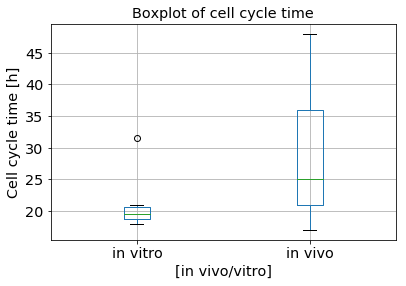

Lifespan of bronchial epithelial cells: 139 days, SD range: 108 - 178  days


In [404]:
#loading the labeling index data
bronc_LI_data = pd.read_excel('Lung_cells_data.xlsx','Bronchi_turnover', index_col=0, usecols=range(7))

#As the uncertainty is small in comparison to the value themselves we use the uncertainty package to propogate the errors
#the total uncertainti is the euclidean sum of the inter and intra errors.
bronc_LI = ufloat(bronc_LI_data['bronchi epithel LI'].mean(),bronc_LI_data['SEM'].mean())+ ufloat(0,bronc_LI_data['bronchi epithel LI'].std()/np.sqrt(bronc_LI_data['bronchi epithel LI'].size))

#transfering the value from linear uncertainty to multiplication fator
bronc_LI_unc = AddErr2MulF(bronc_LI )
bronc_LI=bronc_LI.nominal_value

#loading the cell cycles time data
cell_cycle_data = pd.read_excel('Lung_cells_data.xlsx','Cell_cycle_times', index_col=0, usecols=range(7))

cycles = cell_cycle_data[['in vivo/vitro','TC']].boxplot(by = 'in vivo/vitro', figsize= (6,4))
# set your own proper title
plt.title('Boxplot of cell cycle time')
# get rid of the automatic 'Boxplot grouped by group_by_column_name' title
plt.suptitle('')
plt.ylabel('Cell cycle time [h]')
plt.show()

#deifing a function for extracting the standard error of the relevant data
geo_sem = lambda x: 10**(np.log10(x).std()/np.sqrt(x.size))
 
cycles = cell_cycle_data[['in vivo/vitro','TC']].groupby('in vivo/vitro').agg(gmean)
cycles['SEM'] = cell_cycle_data[['in vivo/vitro','TC']].groupby('in vivo/vitro').agg(geo_sem)


'''
we want to use the cell cycle of cells in vivo, but we want to tale in acount that there is data just on limited number of tissues.
in order to do that we combine the uncertainty with that of the in vitro cells:
1. We use a log10 to translate the error into trems of linear error in logspace (as logX is a normal variable)
2. We use the SEM of the inter-estimates by computing the STD of the log values and divid by sqrt(2)
3. We combine the two types of error: intra/inter-estimate in the logspace using euclidean error propogation 
4. We take the 10th power of the error in the logspace as the multiplication uncertainty error for the reference values
'''

#
#using the Uarr2MulF function we defined to estimate a linear error term using a multiplication factor, it's input is a unumpy uarray
Tc_log_er = np.log10(cycles['SEM'])
# the intra error is the mean of all the SEM of values 
Tc_intra_error = Tc_log_er.mean()

#the inter error is derived from the variance of the mean values 
Tc_inter_error = np.log10(cycles['TC']).std()/np.sqrt(cycles['TC'].size)
#combining the two terms of error
bronc_Tc_unc = 10**(np.sqrt(Tc_inter_error**2+Tc_intra_error**2))
bronc_Tc = cycles.loc['in vivo','TC']

'''
using the labeling index combined with the cell cycle length to estimate the lifespan:
the uncertainty is propogated using the 'FacMulProp' utility function 
'''

bronc_lifespan =bronc_Tc/24/bronc_LI #converting from hours to days
bronc_lifespan_unc = FacMulProp([bronc_Tc_unc,bronc_LI_unc])

# print('TC: ',round(bronc_Tc_unc,2))
# print('LI: ',round(bronc_LI_unc,2))
# print('total: ',round(bronc_lifespan_unc,2))



lung_results.loc['bronchial epithelial cells','lifespan'] =bronc_lifespan,bronc_lifespan_unc.round(2)
PrintMulParmeter('bronchial epithelial cells','lifespan')

### Alveolar epithelium and Interstitial cells turnover
As we could't find any source that measured the cellular turnover or lifespan of these cells in human, we use sources for the lifespan in mice ([Shorter et al., 1964](https://www.ncbi.nlm.nih.gov/pubmed/14148147), [Bowden, 1983](https://www.ncbi.nlm.nih.gov/pubmed/6881708), [Seyed-Razavi et al., 2013](https://www.ncbi.nlm.nih.gov/pubmed/24014685)) and extrapolate from the using a regression from comparison of human and mice cells lifespans

In [435]:
mice_to_data = pd.read_excel('Lung_cells_data.xlsx','Mice_turnover', index_col=0, usecols=range(5), skipfooter=1)

%run Mouse_comparison.ipynb

mice_to_data['mul unc'] = Uarr2MulF(unumpy.uarray(mice_to_data['lifespan [d]'],mice_to_data['SD']))

#adding columns so that the predicted values could be put there
mice_to_data['lifespan in human']=float('NaN')
mice_to_data['human lifespan unc']=float('NaN')

#using the prediction method from the notebook mouse comparison, that also gets and gives uncertainties
mice_to_data[['lifespan in human','human lifespan unc']]=Pred_With_Unc(mice_to_data[['lifespan [d]','mul unc']].values)

for cell_type in mice_to_data.index:
    lung_results.loc[cell_type,'lifespan'] = mice_to_data.loc[cell_type,'lifespan in human'] ,mice_to_data.loc[cell_type,'human lifespan unc'].round(2)
    PrintMulParmeter(cell_type,'lifespan')

Lifespan of alveolar epithelial cells: 132 days, SD range: 100 - 174  days
Lifespan of lung interstitial cells: 201 days, SD range: 156 - 260  days


## Cellular and cellular mass turnover rates
Using the lifespan, mass and number of cells we can estimate the cellular turnvoer and cellular mass turnover rates of the different cells:

In [432]:
#using zip(*) to unzip the tuples so the values and uncertainties can be used to compute the turnover rates
numbers = list(zip(*lung_results['number']))
numbers_vals = np.array(numbers[0])
numbers_unc = np.array(numbers[1])

lifespans = list(zip(*lung_results['lifespan']))
lifespans_vals = np.array(lifespans [0])
lifespans_unc = np.array(lifespans [1])

masses = list(zip(*lung_results['total cellular mass']))
masses_vals = np.array(masses[0])
masses_unc = np.array(masses[1])

lung_results['cellular turnovr rate'] = list(zip(numbers_vals/lifespans_vals, FacMulProp([numbers_unc,lifespans_unc]).round(2)))
lung_results['cellular mass turnovr rate'] =list(zip( masses_vals/lifespans_vals, FacMulProp([masses_unc,lifespans_unc]).round(2)))

for param in ['cellular turnovr rate', 'cellular mass turnovr rate']:
    print('\x1b[1m'+ param.capitalize()+ ':'+'\x1b[0m')
    for cell_type in lung_results.index:
        PrintMulParmeter(cell_type,param)
    print('___________________')


Cellular turnovr rate:
Cellular turnovr rate of alveolar epithelial cells: 8.3e+08 cells per day, SD range: 6.0e+08 - 1.1e+09  cells per day
Cellular turnovr rate of alveolar macrophages: 1.8e+08 cells per day, SD range: 9.7e+07 - 3.2e+08  cells per day
Cellular turnovr rate of bronchial epithelial cells: 7.5e+07 cells per day, SD range: 5.7e+07 - 9.9e+07  cells per day
Cellular turnovr rate of lung interstitial cells: 6.8e+08 cells per day, SD range: 5.1e+08 - 9.0e+08  cells per day
___________________
Cellular mass turnovr rate:
Cellular mass turnovr rate of alveolar epithelial cells: 1.8 grams per day, SD range: 1.3 - 2.6  grams per day
Cellular mass turnovr rate of alveolar macrophages: 0.4 grams per day, SD range: 0.2 - 0.7  grams per day
Cellular mass turnovr rate of bronchial epithelial cells: 0.1 grams per day, SD range: 0.0 - 0.1  grams per day
Cellular mass turnovr rate of lung interstitial cells: 0.5 grams per day, SD range: 0.4 - 0.7  grams per day
___________________


array([1.090000e+11, 2.900000e+10, 1.042829e+10, 1.365000e+11])

## Saving the results to excell

In [1]:
to_excell =pd.DataFrame(index = range(6), columns=['Parameter','Value','Units','Uncertainty','Comments']) 

to_excell['Parameter'] =  pd.Series(lung_results.columns)
to_excell['Units'] = pd.Series(list(UNITS.values()))

file = 'Summary.xlsx'
book = load_workbook(file)
writer = pd.ExcelWriter(file, engine = 'openpyxl')
writer.book = book

writer.sheets = dict((ws.title, ws) for ws in book.worksheets)
sheet=writer.book.active
    
#we go through the types of cells and for each we arrange the results in a dataframe for extracting to excel.

for cell_type in lung_results.index:  
    to_excell['Value'] =  list(zip(*lung_results.loc[cell_type]))[0]
    to_excell['Uncertainty'] =  list(zip(*lung_results.loc[cell_type]))[1]
    to_excell['Comments'] = ('mouse based, ' if cell_type in ['alveolar epithelial cells','lung interstitial cells'] else '') +'uncertainty by multiplication factor'  
    to_excell.to_excel(writer, sheet_name =  cell_type.capitalize() ,index=False)
    worksheet = writer.sheets[cell_type.capitalize()]   
#     using the colors defined in the color sheet to color the tabs. Using the extraction of the data in the Utility_Functions.ipynb notebook
    worksheet.sheet_properties.tabColor= colors_data.loc[cell_type.capitalize(),'hex'] 
    writer.save()

NameError: name 'pd' is not defined